In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream
import numpy as np
import matplotlib.pyplot as plt
import pandas

### Figure 3D

In [2]:
# Load the data file "PredInsights_Agg_sorted_odor_data.txt".  
df = pandas.read_csv('../../data/PredInsights_Agg_sorted_odor_data.txt', 
                     delimiter='\t')
# First 5 rows of loaded data.  
df.head()

,CID,Mean Correlation,Upper(95),Lower(95)
0,11567,0.992470,0.996283,0.988656
1,7797,0.990325,0.993448,0.987202
2,18467,0.986352,0.988279,0.984425
3,17898,0.982546,0.996641,0.968451
4,637758,0.982176,0.986457,0.977895


In [3]:
worst5 = df.iloc[-5:,0].as_matrix()
print("5 CIDs with lowest mean correlation:\n%s" % worst5)
rest64 = df.iloc[:64,0].as_matrix()
print("64 CIDs with highest mean correlation:\n%s" % rest64)

5 CIDs with lowest mean correlation:
[ 753 7657 8025 5962 5862]
64 CIDs with highest mean correlation:
[   11567     7797    18467    17898   637758    61523     7793    60998
     7137     6544  5281168   251531  5318599    12020  2733294     8878
     7770     8815     6669    62351      323 10857465     3314  5364231
    31283    31276     7092     7559  5371102   853433  5352837     7476
    62089     8094    62465     1031    21363     8468    31219    15654
      264      750     8438      702     6322    10886    27440    12265
  5281167     9012     8419    12377      262      180     6561      962
     8049    16537   440917     7302     6506     6274  1549025     3102]


In [4]:
# Load the CIDs and dilutions for the testset.  
CIDs = loading.get_CIDs("testset")
CID_dilutions = loading.get_CID_dilutions("testset",target_dilution=-3) # Dilution is irrelevant here.  

In [5]:
# Load the molecular descriptors data.  
molecular_headers, molecular_data = loading.load_molecular_data()
molecular_vectors = dream.get_molecular_vectors(molecular_data,CID_dilutions)

In [6]:
worst5_features = np.array([molecular_vectors[x] for x in worst5])
print("Feature matrix for worst 5 molecules has shape (%d,%d)" % worst5_features.shape)

rest64_features = np.array([molecular_vectors[x] for x in rest64])
print("Feature matrix for other 64 molecules has shape (%d,%d)" % rest64_features.shape)

Feature matrix for worst 5 molecules has shape (5,4869)
Feature matrix for other 64 molecules has shape (64,4869)


In [7]:
from scipy.stats import ttest_ind as ttest, ranksums as wilcoxon
n_features = worst5_features.shape[1]
p_values = {}
for i in range(n_features):
    worst5 = worst5_features[:,i]
    worst5 = worst5[np.isfinite(worst5)] # Remove NaN values so the t-test can proceed.  
    rest64 = rest64_features[:,i]
    rest64 = rest64[np.isfinite(rest64)] # Remove NaN values so the t-test can proceed. 
    t,p_t = ttest(worst5, rest64, axis=0)
    _,p_w = wilcoxon(worst5, rest64)
    feature = molecular_headers[i+1] # +1 to avoid the CID index.  
    p_values[feature] = {'p_t':p_t, 
                         'p_w':p_w,
                         'bad_mean':worst5.mean(), 
                         'rest_mean':rest64.mean(),
                         'bad_n':worst5.size,
                         'rest_n':rest64.size}

In [8]:
df = pandas.DataFrame(data=p_values).transpose()
df = df[['p_t', 'p_w', 'bad_mean', 'rest_mean', 'bad_n', 'rest_n']]
df_t = df.sort_values('p_t')
df_t[:10] # Smallest 10 p-values.  

,p_t,p_w,bad_mean,rest_mean,bad_n,rest_n
CATS2D_03_DD,0.000003,0.041670,0.8000,0.062500,5,64
HATS4s,0.000059,0.055493,3.9588,1.651302,5,63
R4s+,0.000073,0.061761,0.9992,0.402317,5,63
G(O..S),0.000196,0.458902,1.4778,0.000000,5,64
CATS2D_07_DP,0.000196,0.458902,0.2000,0.000000,5,64
CATS2D_07_DD,0.000196,0.458902,0.2000,0.000000,5,64
NsSH,0.000196,0.458902,0.2000,0.000000,5,64
CATS2D_07_DA,0.000196,0.458902,0.2000,0.000000,5,64
CATS2D_07_AP,0.000196,0.458902,0.2000,0.000000,5,64
nSH,0.000196,0.458902,0.2000,0.000000,5,64


#### How does this compare to the results computed previously by Amit?

In [9]:
# Compare to the results in the pre-computed "PredInsights_Fdiffodor.txt" file.  
df_static = pandas.read_csv('../../data/PredInsights_Fdiffodor.txt', 
                     delimiter='\t')
# First 5 rows of loaded data.  
df_static[:10]

,Feature,p-value,BadMean,RestMean
0,CATS2D_03_DD,0.000003,0.8000,0.062500
1,HATS4s,0.000055,3.9588,1.625500
2,R4s+,0.000066,0.9992,0.396031
3,SsSH,0.000196,0.7298,0.000000
4,G(O..S),0.000196,1.4778,0.000000
5,nSH,0.000196,0.2000,0.000000
6,S-106,0.000196,0.2000,0.000000
7,NsSH,0.000196,0.2000,0.000000
8,CATS2D_07_DD,0.000196,0.2000,0.000000
9,CATS2D_07_DA,0.000196,0.2000,0.000000


##### The results are similar, some p-values are slightly different.  
##### The difference of entries 3-10 is probably arbitrary due to tie-breaking of values sharing p=0.00196
##### Let's look at the distribution of values for the top 10.  

Example:
Worst 5 for nSH:
[ 0.  0.  0.  0.  1.]
Rest 64 for nSH:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


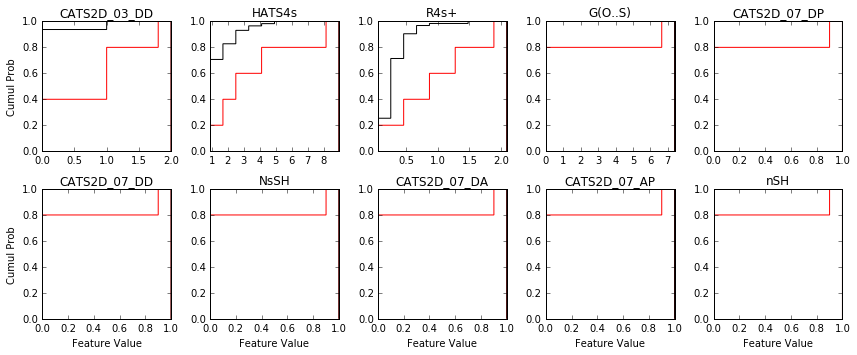

In [10]:
def plot_feature_hist(df):
    top10 = df[:10].index
    fig, axes = plt.subplots(2,5,figsize=(12,5))
    for i in range(10):
        ax = axes.flat[i]
        feature = top10[i]
        index = molecular_headers.index(feature)-1
        worst5 = worst5_features[:,index]
        rest64 = rest64_features[:,index]
        low = min(worst5.min(),rest64.min())
        high = max(worst5.max(),rest64.max())
        ax.hist(worst5,range=(low,high),normed=True,cumulative=True,histtype='step',color='r')
        ax.hist(rest64,range=(low,high),normed=True,cumulative=True,histtype='step',color='k')
        ax.set_xlim(low,high)
        ax.set_title(feature)
        if i % 5 == 0:
            ax.set_ylabel('Cumul Prob')
        if i >= 5:
            ax.set_xlabel('Feature Value')
        if i==9:
            print("Example:")
            print("Worst 5 for %s:\n%s" % (feature,np.sort(worst5)))
            print("Rest 64 for %s:\n%s" % (feature,np.sort(rest64)))
    plt.tight_layout()
plot_feature_hist(df_t)

#### But a completely different set of features are obtained if we switch to a Wilcoxon rank-sum test:

In [11]:
df_w = df.sort_values('p_w')
df_w[:10] # Smallest 10 p-values.  

,p_t,p_w,bad_mean,rest_mean,bad_n,rest_n
SsCH3,0.015229,0.006311,0.3516,2.832453,5,64
P_VSA_LogP_1,0.019056,0.007774,1.7650,13.775141,5,64
MATS5v,0.049849,0.008045,0.1882,-0.034922,5,64
NsCH3,0.015321,0.008911,0.2000,1.500000,5,64
MATS2m,0.021959,0.009534,-0.1600,0.003875,5,64
R2u,0.067865,0.009534,1.5796,1.808109,5,64
G1i,0.218281,0.009534,0.3838,0.256906,5,64
G1u,0.217466,0.013701,0.3890,0.263031,5,64
MATS5p,0.018659,0.014150,0.1836,-0.025250,5,64
Mor28u,0.028558,0.014150,-0.0342,-0.272891,5,64


Example:
Worst 5 for Mor28u:
[-0.224 -0.072 -0.046  0.002  0.169]
Rest 64 for Mor28u:
[-0.996 -0.935 -0.716 -0.639 -0.638 -0.621 -0.589 -0.572 -0.568 -0.502
 -0.495 -0.468 -0.468 -0.417 -0.417 -0.397 -0.385 -0.378 -0.337 -0.334
 -0.334 -0.333 -0.324 -0.309 -0.306 -0.306 -0.298 -0.263 -0.263 -0.262
 -0.259 -0.245 -0.243 -0.237 -0.228 -0.225 -0.218 -0.218 -0.201 -0.199
 -0.193 -0.175 -0.161 -0.126 -0.117 -0.11  -0.107 -0.107 -0.097 -0.085
 -0.083 -0.075 -0.064 -0.064 -0.058 -0.054 -0.043 -0.033 -0.023  0.016
  0.056  0.081  0.127  0.173]


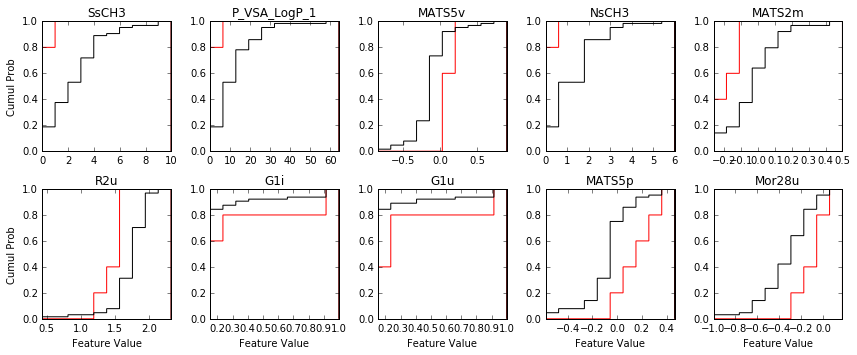

In [12]:
plot_feature_hist(df_w)